In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import pandas as pd
from geopy.geocoders import Nominatim
from matplotlib.colors import SymLogNorm
from matplotlib.pyplot import cm
import matplotlib
from matplotlib.gridspec import GridSpec

import xesmf as xe
#from pykrige.ok import OrdinaryKrigingg
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import dask
import utils
import os

import cartopy.feature
from cartopy.mpl.patch import geos_to_path
import cartopy.crs as ccrs

import geopandas

In [2]:
years = 50
countries = ['MALAYSIA','CAMBODIA','INDONESIA','VIETNAM']
## Add time dimension
length_simulation = years*365
time_array = np.arange(0, length_simulation)
shutdown_years = np.arange(2000,2061,1)

In [3]:
CGP_df = pd.read_csv('mod_coal_inputs/BC_SE_Asia_all_financing_SEA_GAINS_Springer.csv')
CGP_df.columns = CGP_df.columns.str.replace(' ', '_')

CGP_df = CGP_df.rename(columns = {'YEAR':'Year_of_Commission', 'EMISFACTOR.PLATTS':'CO2_weighted_capacity_1000tonsperMW'})
min_year = CGP_df['Year_of_Commission'].min()
print('Emis data prepped and loaded')


######## Country mask and dataframe ######

country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_50
country_df = geopandas.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
impacted_countries = ['China','Australia', 'India','Myanmar',  'Laos','Philippines','Nepal','Bangladesh','Thailand','Bhutan','Brunei', 'Papua New Guinea', 'Solomon Islands', 'East Timor', 'Taiwan']
country_df = country_df.rename(columns = {'SOVEREIGNT':'country'})

ds_area = xr.open_dataset('/net/fs11/d0/emfreese/GCrundirs/IRF_runs/stretch_2x_pulse/SEA/Jan/mod_output/GEOSChem.SpeciesConc.20160101_0000z.nc4', engine = 'netcdf4')
utils.fix_area_ij_latlon(ds_area);


Emis data prepped and loaded


In [4]:
#convert from g/day to kg/yr
days_per_year = 365
g_per_kg = 1000
CGP_df['BC_(kg/yr)'] = CGP_df['BC_(g/day)'] * days_per_year/g_per_kg #g/year

In [5]:
#add in the radiative forcing by location (need to get citation)
Tg_per_kg = 1e9
rad_force_dict = {'MALAYSIA': 1.32e-2/Tg_per_kg, 'INDONESIA':1.17e-2/Tg_per_kg, 'VIETNAM':1.30e-2/Tg_per_kg, 'CAMBODIA':1.81e-2/Tg_per_kg} #units = W/m2/Tg  BC

for c in rad_force_dict.keys():
    CGP_df.loc[CGP_df['COUNTRY'] == c,'rad_forcing_wperm2perkg'] = rad_force_dict[c]

In [6]:
#calculate the years of operation, emissions for that amount of time, and radiative forcing over that time for all plants (if they are running for up to 40 years or less)
E_CO2_all_opts = {}
Emis_CO2_all_opts = {}
Rad_forcing_all_opts = {}

#raw emission data
emis_ds = xr.DataArray(data = CGP_df.loc[(CGP_df['BC_(kg/yr)'] >0)]['BC_(kg/yr)'].values,
                        dims = ['unique_ID'],
                        coords = dict(unique_ID = 
                                      CGP_df.loc[(CGP_df['BC_(kg/yr)'] >0)].index),
                        attrs = dict(description = 'emissions of BC from each unique power plant in our four countries',
                                    units = 'kg/yr'))
#raw radiative forcing
rad_force_ds = xr.DataArray(data = CGP_df.loc[(CGP_df['BC_(kg/yr)'] >0)]['rad_forcing_wperm2perkg'].values,
                        dims = ['unique_ID'],
                        coords = dict(unique_ID = 
                                      CGP_df.loc[(CGP_df['BC_(kg/yr)'] >0)].index),
                        attrs = dict(description = 'radiative forcing for each of our unique plants',
                                    units = 'w/m2/kg'))


#for each early shutdown year
for yr in shutdown_years:
    #calculate the years until shutdown for each plant
    E_CO2_all_opts[yr] = ((yr- CGP_df.loc[(CGP_df['BC_(kg/yr)'] >0)]['Year_of_Commission'] ))
    #make datasets
    E_CO2_all_opts[yr] = xr.DataArray(data = E_CO2_all_opts[yr].values,
                                dims = ['unique_ID'],
                                coords = dict(unique_ID = 
                                              CGP_df.loc[(CGP_df['BC_(kg/yr)'] >0)].index),
                                attrs = dict(description = 'years that each power plant operates under a given early shutdown',
                                            units = 'yrs'))
    

    #make sure the plants are operating, and that they don't exceed their lifetime (estimated 40 years)
    E_CO2_all_opts[yr] = E_CO2_all_opts[yr].where(E_CO2_all_opts[yr] > 0).fillna(0)
    E_CO2_all_opts[yr] = E_CO2_all_opts[yr].where(E_CO2_all_opts[yr] <= 40).fillna(40)
    #make a dataset of the emissions*years of operation
    Emis_CO2_all_opts[yr] = E_CO2_all_opts[yr]*emis_ds
    Emis_CO2_all_opts[yr].attrs['units'] = 'kg'
    #make a dataset of the forcing
    Rad_forcing_all_opts[yr] = Emis_CO2_all_opts[yr]*rad_force_ds
    Rad_forcing_all_opts[yr].attrs['units'] = 'w/m2'
    
#concatenate into a dataset
E_ds = xr.concat([E_CO2_all_opts[m] for m in E_CO2_all_opts.keys()], pd.Index([m for m in E_CO2_all_opts.keys()], name='closure_year'), join = 'outer')
Emis_ds = xr.concat([Emis_CO2_all_opts[m] for m in Emis_CO2_all_opts.keys()], pd.Index([m for m in Emis_CO2_all_opts.keys()], name='closure_year'), join = 'outer')
Rad_F_ds = xr.concat([Rad_forcing_all_opts[m] for m in Rad_forcing_all_opts.keys()], pd.Index([m for m in Rad_forcing_all_opts.keys()], name='closure_year'), join = 'outer')


In [7]:
country_id_ds = CGP_df.loc[CGP_df['BC_(kg/yr)'] >0][['COUNTRY','unique_ID','CO2_weighted_capacity_1000tonsperMW', 'ANNUALCO2', 'MW',
                                                      'CON.COUNTRY', 'PAR.COUNTRY', 'AE.COUNTRY','Year_of_Commission', 'rad_forcing_wperm2perkg']].groupby('unique_ID').first().to_xarray()

In [8]:
#make a dataset of the max lifetime possible
max_E_ds = xr.ones_like(E_ds)*40

In [9]:
ug_to_ng = 1e3

In [12]:
######### import the convolutions ###############
conv_df = {}
for c in countries:
    for unique_id in CGP_df.loc[(CGP_df['COUNTRY'] == c) & (CGP_df['BC_(kg/yr)'] >0)]['unique_ID'].values:
        if os.path.exists(f'Outputs/individual_shutdowns/single_year/all_funders/C_out_{c}_{unique_id}_uniqueid_single_yr.nc'):
            print()
        else:
            print(f'{c} {unique_id}')
            
#         conv_df[unique_id] = pd.read_csv(f'Outputs/individual_shutdowns/single_year/C_out_{c}_{unique_id}_uniqueid_single_yr.nc', index_col = 0)
#         conv_df[unique_id] = conv_df[unique_id].to_xarray().rename({'index':'country_impacted'})
        
        
# conv_ds = xr.concat([conv_df[t] for t in conv_df.keys()], pd.Index([t for t in conv_df.keys()], name='unique_ID'), join = 'outer')*ug_to_ng

















MALAYSIA 186
MALAYSIA 281
MALAYSIA 314
MALAYSIA 315




CAMBODIA 265
CAMBODIA 317




INDONESIA 5
INDONESIA 6
INDONESIA 7
INDONESIA 8
INDONESIA 9
INDONESIA 10
INDONESIA 11
INDONESIA 12
INDONESIA 13
INDONESIA 14
INDONESIA 15
INDONESIA 18
INDONESIA 19
INDONESIA 20
INDONESIA 21
INDONESIA 22
INDONESIA 24
INDONESIA 25
INDONESIA 26
INDONESIA 27
INDONESIA 28
INDONESIA 29
INDONESIA 30
INDONESIA 31
INDONESIA 32
INDONESIA 44
INDONESIA 45
INDONESIA 46
INDONESIA 47
INDONESIA 48
INDONESIA 49
INDONESIA 50
INDONESIA 51
INDONESIA 52
INDONESIA 56
INDONESIA 57
INDONESIA 58
INDONESIA 61
INDONESIA 62
INDONESIA 63
INDONESIA 64
INDONESIA 65
INDONESIA 70
INDONESIA 71
INDONESIA 72
INDONESIA 73
INDONESIA 74
INDONESIA 75
INDONESIA 76
INDONESIA 77
INDONESIA 78
INDONESIA 79
INDONESIA 82
INDONESIA 83
INDONESIA 84
INDONESIA 85
INDONESIA 98
INDONESIA 99
INDONESIA 100
INDONESIA 101
INDONESIA 102
INDONESIA 103
INDONESIA 104
INDONESIA 108
INDONESIA 109
INDONESIA 110
INDONESIA 111
INDONESIA 112
INDONESIA

In [14]:
conv_ds

In [23]:
E_ds.name = 'emis_profiles'
max_E_ds.name = 'remaining_emis_profiles'

In [24]:
E_ds.attrs['units'] = 'none'
max_E_ds.attrs['units'] = 'none'

In [25]:
co2_ds = E_ds*country_id_ds['ANNUALCO2']
co2_ds.name = 'co2_emissions'

max_co2_ds = max_E_ds*country_id_ds['ANNUALCO2']
max_co2_ds.name = 'max_co2_emissions'

In [26]:
mw_ds = E_ds*country_id_ds['MW']
mw_ds.name = 'MW_total'

max_MW_ds = max_E_ds*country_id_ds['MW']
max_MW_ds.name = 'max_MW_total'

INDIA NDE  2.61E-02

INDON IDN  1.17E-02

THAIL THA 1.45E-02 

MALYS MYS  1.32E-02 

PHIL PHL 8.79E-03 

VTNAM VNM  1.30E-02 

REST OF EAS RSEA  1.81E-02 

In [27]:
Emis_ds.name = 'BC_emissions'

rad_force_ds = country_id_ds['rad_forcing_wperm2perkg']*Emis_ds

k_per_tg_per_yr = 0.04 #https://acp-copernicus-org.libproxy.mit.edu/articles/20/3079/2020/ Sand et al.
temp_ds = Emis_ds/Tg_per_kg

rad_force_ds.name = 'BC_forcing'
rad_force_ds.attrs = {'units':'W/m2'}

temp_ds.name = 'BC_temp'
temp_ds.attrs = {'units':'K'} 

In [20]:
full_ds = xr.merge([country_id_ds, E_ds*conv_ds,  (max_E_ds*conv_ds).rename({'BC_mean_Conc':'final_BC_mean_Conc', 'BC_pop_weight_mean_conc':'final_BC_pop_weight_mean_conc'}), co2_ds, final_co2_ds, mw_ds, final_MW_ds]).rename({'COUNTRY':'country_emitting'})

#convert to ng/m3 (from ng/m3/yr)
delta_t = full_ds['closure_year'].max().values - min_year
for val in ['BC_mean_Conc', 'BC_pop_weight_mean_conc',  'final_BC_mean_Conc', 'final_BC_pop_weight_mean_conc', 'MW_total', 'final_MW_total']:
    full_ds[val]/=delta_t
    full_ds[val].attrs = {'units':'ng/m3'}

In [21]:
gdf = country_df[country_df['country'].isin(impacted_countries)][['country','geometry']].rename(columns = {'country':'country_impacted'}).set_index('country_impacted')

In [22]:
map_locations = ['MALAYSIA', 'CAMBODIA', 'INDONESIA', 'VIETNAM', 'all']

In [23]:
bc_pop_weight_mean = {}
for loc in map_locations:
    print(loc)
    bc_pop_weight_mean[loc] = {}
    for yr in shutdown_years:
        bc_pop_weight_mean[loc][yr] = pd.merge(gdf, 
                                               full_ds.where(full_ds.country_emitting == loc, drop = True).sel(closure_year = yr)['BC_pop_weight_mean_conc'].sum(dim = 'unique_ID').to_dataframe(), 
                                               on = 'country_impacted')
        


for yr in shutdown_years:
    bc_pop_weight_mean['all'][yr] = pd.merge(gdf, 
                                             full_ds['BC_pop_weight_mean_conc'].sel(closure_year = yr).sum(dim = 'unique_ID').to_dataframe(), 
                                             on = 'country_impacted')

MALAYSIA
CAMBODIA
INDONESIA
VIETNAM
all


In [33]:
bc_pop_weight_mean['all'][2020]

geometry  \
country_impacted                                                      
India             MULTIPOLYGON (((77.80035 35.49541, 77.81533 35...   
China             MULTIPOLYGON (((78.91769 33.38626, 78.91595 33...   
China             MULTIPOLYGON (((114.22983 22.55581, 114.23471 ...   
China             MULTIPOLYGON (((113.55860 22.16303, 113.56943 ...   
Bhutan            POLYGON ((90.47523 28.07234, 90.49259 28.07441...   
Laos              POLYGON ((102.11866 22.39755, 102.12542 22.383...   
Thailand          MULTIPOLYGON (((102.91358 11.64590, 102.90602 ...   
East Timor        MULTIPOLYGON (((124.45053 -9.18019, 124.45150 ...   
Brunei            MULTIPOLYGON (((115.14617 4.90851, 115.14680 4...   
Myanmar           MULTIPOLYGON (((92.57588 21.97757, 92.58384 21...   
Bangladesh        MULTIPOLYGON (((92.57588 21.97757, 92.59024 21...   
Nepal             POLYGON ((88.11822 27.86088, 88.14302 27.85572...   
Papua New Guinea  MULTIPOLYGON (((140.97446 -2.60052, 140.98732 ...   
Australia         MULTIPOLYGON (((131.53590 -31.60556, 131.34555...   
Australia         POLYGON ((73.73512 -53.11240, 73.76189 -53.118...   
Australia         MULTIPOLYGON (((96.86313 -12.18174, 96.86940 -...   
Australia         POLYGON ((167.98414 -29.01784, 167.99635 -29.0...   
Australia         POLYGON ((154.39129 -21.03004, 154.38852 -21.0...   
Australia         POLYGON ((123.59702 -12.42832, 123.59775 -12.4...   
Philippines       MULTIPOLYGON (((120.86069 5.57437, 120.87306 5...   
Taiwan            MULTIPOLYGON (((121.90577 24.95010, 121.83473 ...   
Solomon Islands   MULTIPOLYGON (((160.50367 -11.73602, 160.56446...   

                  closure_year  BC_pop_weight_mean_conc  
country_impacted                                         
India                     2020                 0.000095  
China                     2020                 0.001625  
China                     2020                 0.001625  
China                     2020                 0.001625  
Bhutan                    2020                 0.000407  
Laos                      2020                 0.006458  
Thailand                  2020                 0.009972  
East Timor                2020                 0.000016  
Brunei                    2020                 0.037826  
Myanmar                   2020                 0.000539  
Bangladesh                2020                 0.000205  
Nepal                     2020                 0.000225  
Papua New Guinea          2020                 0.000024  
Australia                 2020                 0.000006  
Australia                 2020                 0.000006  
Australia                 2020                 0.000006  
Australia                 2020                 0.000006  
Australia                 2020                 0.000006  
Australia                 2020                 0.000006  
Philippines               2020                 0.000679  
Taiwan                    2020                 0.000423  
Solomon Islands           2020                 0.000006

In [24]:
all_countries = impacted_countries.copy()

In [25]:
all_countries.append('Malaysia')
all_countries.append('Cambodia')
all_countries.append('Indonesia')
all_countries.append('Vietnam')

In [28]:
import matplotlib as mpl

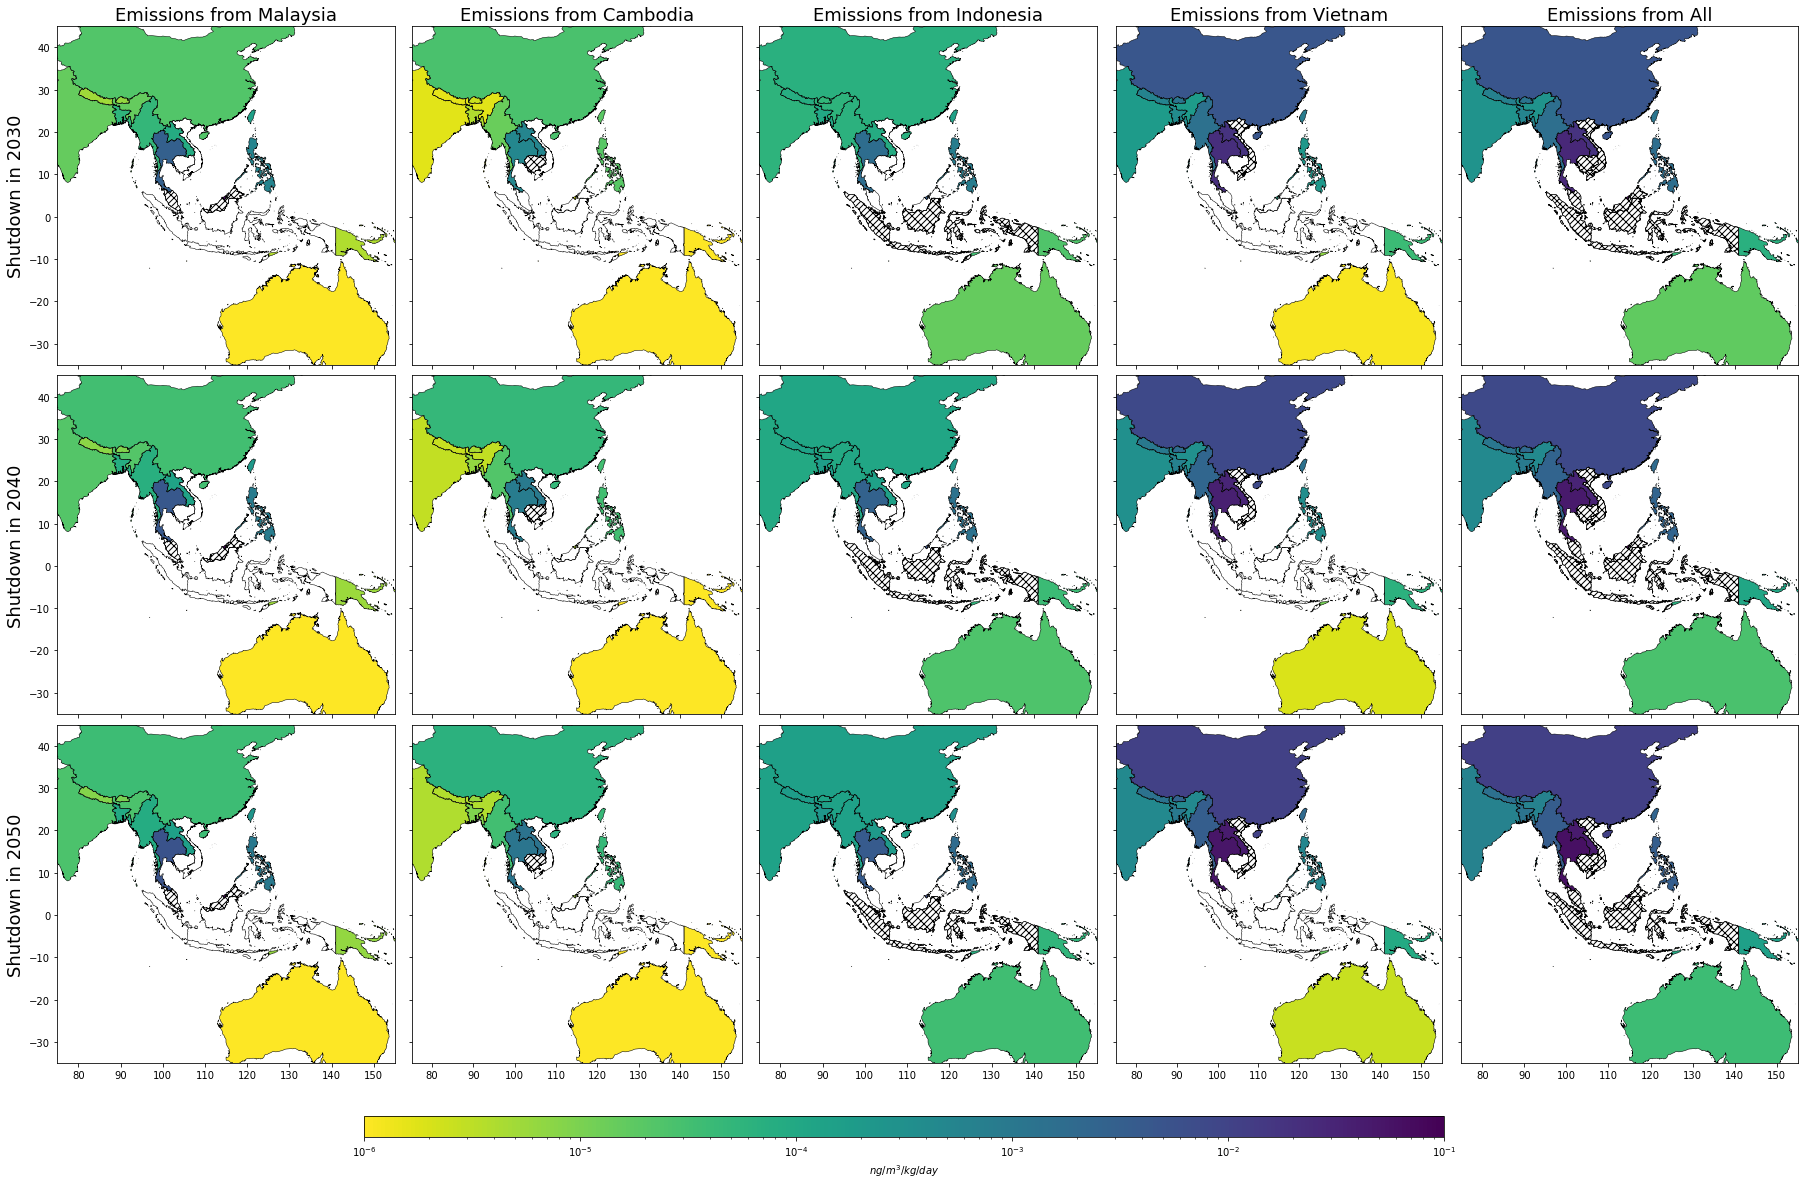

In [29]:
vmax_dict = {
    'MALAYSIA': 10,
    'CAMBODIA': 10,
    'INDONESIA': 100,
    'VIETNAM': 1000,
    'all': 1000,
    
}

fig, axes = plt.subplots(3,5, figsize = (25,15), sharex = True, sharey = True, constrained_layout = True)
for idx_m, loc in enumerate(map_locations):
    for idx_t, t in enumerate(np.arange(2030,2060)[::10]):
        ax = axes[idx_t,idx_m]
        bc_pop_weight_mean[loc][t].plot(ax = ax, column =  'BC_pop_weight_mean_conc',  cmap = 'viridis_r',  norm=matplotlib.colors.LogNorm(vmin = 1e-6, vmax = 1e-1))
        country_df[country_df['country'].isin(all_countries)].boundary.plot(ax = ax, color = 'k', linewidth = .5)
    
        if loc == 'MALAYSIA' or loc == 'CAMBODIA' or loc == 'INDONESIA' or loc == 'VIETNAM':
             country_df[country_df['country'] == loc.capitalize()].boundary.plot(ax = ax, color = 'k', linewidth = .5, hatch="\\\\////")
        
        if loc == 'all':
            country_df[country_df['country'].isin(['Vietnam','Indonesia','Cambodia','Malaysia'])].boundary.plot(ax = ax, color = 'k', linewidth = .5, hatch="\\\\////")
            
    
        axes[0,idx_m].set_title(f'Emissions from {loc.capitalize()}', fontsize = 18);
        axes[idx_t,0].set_ylabel(f'Shutdown in {t}', fontsize = 18);
        ax.set_xlim(75,155)
        ax.set_ylim(-35,45)
        

cb_ax = fig.add_axes([0.2, -0.05, 0.6, 0.02])
mpl.colorbar.ColorbarBase(ax = cb_ax, cmap = 'viridis_r', norm = matplotlib.colors.LogNorm(vmin = 1e-6, vmax = 1e-1), 
                          orientation = 'horizontal', label = '$ng/m^3/kg/day$')

plt.savefig('figures/paper/maps.png', bbox_inches = 'tight', dpi = 300)

In [43]:
norm_bc_pop_weight_mean = {}
for loc in map_locations:
    print(loc)
    norm_bc_pop_weight_mean[loc] = {}
    for yr in shutdown_years:
        norm_bc_pop_weight_mean[loc][yr] = bc_pop_weight_mean[loc][yr].copy()
        
for loc in ['MALAYSIA', 'CAMBODIA', 'INDONESIA', 'VIETNAM']:
    print(loc)
    for yr in shutdown_years:
        norm_bc_pop_weight_mean[loc][yr]['BC_pop_weight_mean_conc'] = norm_bc_pop_weight_mean[loc][yr]['BC_pop_weight_mean_conc']/(CGP_df.groupby('COUNTRY').sum()['BC_(kg/yr)'][loc]*yr)
for yr in shutdown_years:        
    norm_bc_pop_weight_mean['all'][yr]['BC_pop_weight_mean_conc'] = norm_bc_pop_weight_mean['all'][yr]['BC_pop_weight_mean_conc']/(CGP_df.groupby('COUNTRY').sum()['BC_(kg/yr)'].sum()*yr)

MALAYSIA
CAMBODIA
INDONESIA
VIETNAM
all
MALAYSIA
CAMBODIA
INDONESIA
VIETNAM


In [50]:
map_locations

['MALAYSIA', 'CAMBODIA', 'INDONESIA', 'VIETNAM', 'all']

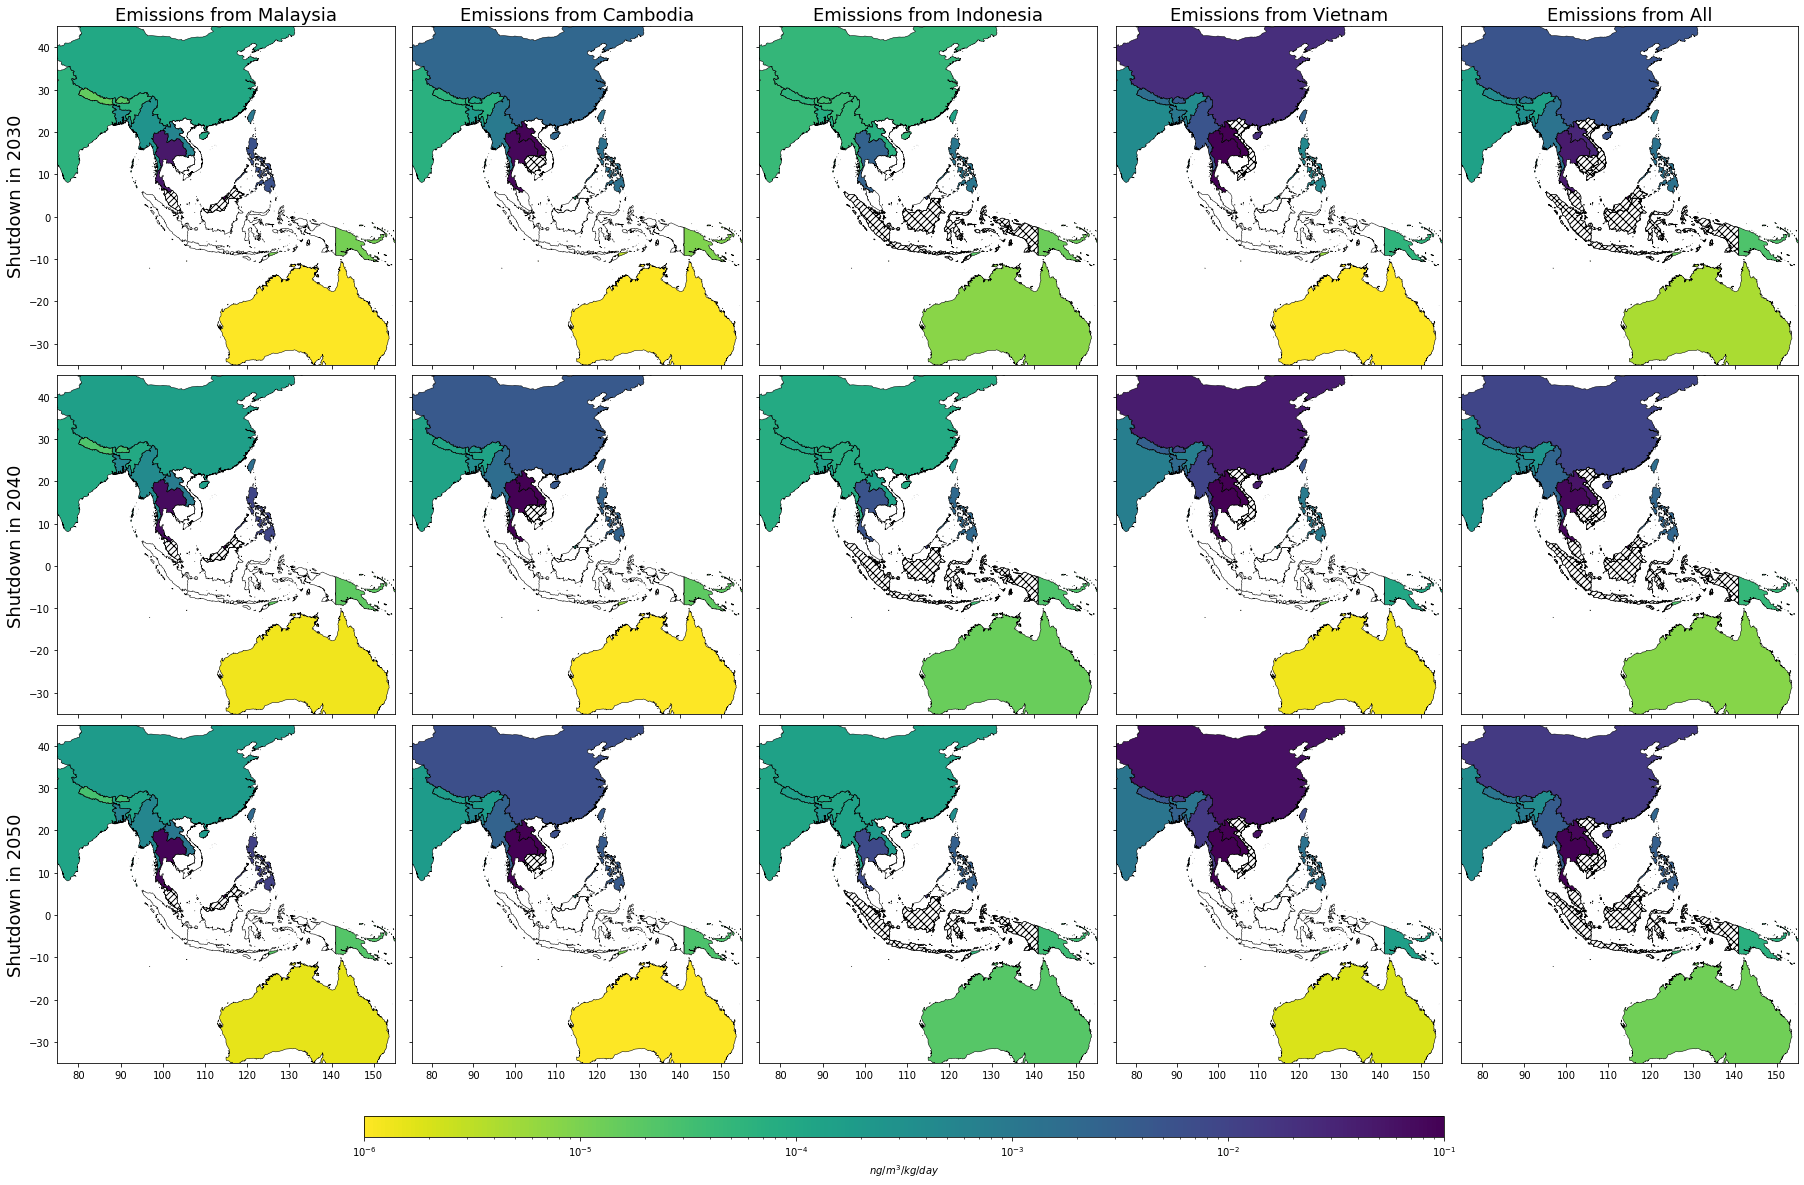

In [58]:
vmax_dict = {
    'MALAYSIA': 10,
    'CAMBODIA': 10,
    'INDONESIA': 100,
    'VIETNAM': 1000,
    'all': 1000,
    
}

fig, axes = plt.subplots(3,5, figsize = (25,15), sharex = True, sharey = True, constrained_layout = True)
for idx_m, loc in enumerate(map_locations):
    for idx_t, t in enumerate(np.arange(2030,2060)[::10]):
        
        ax = axes[idx_t,idx_m]

        (norm_bc_pop_weight_mean[loc][t]).plot(ax = ax, column =  'BC_pop_weight_mean_conc', cmap = 'viridis_r',  
                                               norm=matplotlib.colors.LogNorm(vmin = 1e-17, vmax = 1e-13))
        country_df[country_df['country'].isin(all_countries)].boundary.plot(ax = ax, color = 'k', linewidth = .5)

        if loc == 'MALAYSIA' or loc == 'CAMBODIA' or loc == 'INDONESIA' or loc == 'VIETNAM':
            country_df[country_df['country'] == loc.capitalize()].boundary.plot(ax = ax, color = 'k', linewidth = .5, hatch="\\\\////")
        
        if loc == 'all':
            country_df[country_df['country'].isin(['Vietnam','Indonesia','Cambodia','Malaysia'])].boundary.plot(ax = ax, color = 'k', linewidth = .5, hatch="\\\\////")
            
        axes[0,idx_m].set_title(f'Emissions from {loc.capitalize()}', fontsize = 18);
        axes[idx_t,0].set_ylabel(f'Shutdown in {t}', fontsize = 18);
        ax.set_xlim(75,155)
        ax.set_ylim(-35,45)
        
        

cb_ax = fig.add_axes([0.2, -0.05, 0.6, 0.02])
mpl.colorbar.ColorbarBase(ax = cb_ax, cmap = 'viridis_r', norm = matplotlib.colors.LogNorm(vmin = 1e-6, vmax = 1e-1), 
                          orientation = 'horizontal', label = '$ng/m^3/kg/day$')

plt.savefig('figures/paper/maps_normalized.png', bbox_inches = 'tight', dpi = 300)

## Datasets to analyze shutdown approach


In [59]:

age_ds = {}
bckg_age_ds = {}
for idx, val in enumerate(full_ds['unique_ID'].values):
    age_ds[idx] = full_ds.sortby(
                     ['Year_of_Commission'], ascending = True).isel(unique_ID = slice(0,idx)).sum(dim = ['unique_ID'])
    
    bckg_age_ds[idx] = full_ds.sortby(
                     ['Year_of_Commission'], ascending = True).isel(unique_ID = slice(idx, -1)).sum(dim = ['unique_ID'])
    
age_ds = xr.concat([age_ds[t] for t in age_ds.keys()], pd.Index([t for t in age_ds.keys()], name='unique_ID'), join = 'outer')
bckg_age_ds = xr.concat([bckg_age_ds[t] for t in bckg_age_ds.keys()], pd.Index([t for t in bckg_age_ds.keys()], name='unique_ID'), join = 'outer')


In [67]:
weighted_ds = {}
bckg_weighted_ds = {}
for idx, val in enumerate(full_ds['unique_ID'].values):
    weighted_ds[idx] = full_ds.sortby(
                     ['CO2_weighted_capacity_1000tonsperMW'], ascending = True).isel(unique_ID = slice(0,idx)).sum(dim = ['unique_ID'])
    bckg_weighted_ds[idx] = full_ds.sortby(
                     ['CO2_weighted_capacity_1000tonsperMW'], ascending = True).isel(unique_ID = slice(idx, -1)).sum(dim = ['unique_ID'])
    
weighted_ds = xr.concat([weighted_ds[t] for t in weighted_ds.keys()], pd.Index([t for t in weighted_ds.keys()], name='unique_ID'), join = 'outer')
bckg_weighted_ds = xr.concat([bckg_weighted_ds[t] for t in bckg_weighted_ds.keys()], pd.Index([t for t in bckg_weighted_ds.keys()], name='unique_ID'), join = 'outer')


In [61]:
mw_ds = {}
bckg_mw_ds = {}
for idx, val in enumerate(full_ds['unique_ID'].values):
    mw_ds[idx] = full_ds.sortby(
                     ['MW'], ascending = True).isel(unique_ID = slice(0,idx)).sum(dim = ['unique_ID'])
    bckg_mw_ds[idx] = full_ds.sortby(
                     ['MW'], ascending = True).isel(unique_ID = slice(idx, -1)).sum(dim = ['unique_ID'])
mw_ds = xr.concat([mw_ds[t] for t in mw_ds.keys()], pd.Index([t for t in mw_ds.keys()], name='unique_ID'), join = 'outer')
bckg_mw_ds = xr.concat([bckg_mw_ds[t] for t in bckg_mw_ds.keys()], pd.Index([t for t in bckg_mw_ds.keys()], name='unique_ID'), join = 'outer')


## Incorporating CO2 trajectories

temp_conv = 3*1e-12
co2_to_c = 1/3.67

dict_ds = {0:'Plant Age', 1: 'CO$_2$ Emissions Intensity', 2: 'Plant Size'}
fig, axes = plt.subplots(1,3, figsize = (15,5), sharex = True, sharey = True, constrained_layout = True)
for idx_d, ds in enumerate([age_ds, weighted_ds, mw_ds]):
    ax = axes[idx_d]
    ####BC#######
    ds['BC_temp'].plot.contour(ax = ax, add_colorbar = True,  
                           #vmin = 0, vmax = dict_vmax[impacted_c], 
                              cmap = 'cividis',
                           cbar_kwargs = {'label':'W/m$^2$ forcing'})

    ####CO2######
    contours = (ds['co2_emissions']*co2_to_c*temp_conv).plot.contour(ax = ax, add_colorbar = False, cmap = 'gist_heat_r', 
                               )

    plt.clabel(contours, fontsize=8, inline = True)
    #### TITLES #####
    ax.set_title(None)
    ax.set_title(dict_ds[idx_d], fontsize = 14)
    ax.set_ylabel(None)
    ax.set_xlim(2020,2060)
    axes[0].set_ylabel(f'Number of Plants Operating', fontsize = 12);
    ax.set_xlabel(f'Year of Closure', fontsize = 12);
#plt.savefig('figures/paper/contours_mw.png', bbox_inches = 'tight', dpi = 300)

In [ ]:
dict_ds = {0:'Plant Age', 1: 'CO$_2$ Emissions Intensity', 2: 'Plant Size'}
dict_vmax = {'China':220, 'India': 12, 'Philippines':70}
fig, axes = plt.subplots(3,3, figsize = (15,10), sharex = True, sharey = True, constrained_layout = True)
for idx, impacted_c in enumerate(subset_locations):
    for idx_d, ds in enumerate([age_ds, weighted_ds, mw_ds]):
        ax = axes[idx,idx_d]
        ####BC#######
        ds['BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c).plot(ax = ax, add_colorbar = True,  
                                                                                       #vmin = 0, vmax = dict_vmax[impacted_c], 
                                                                                          cmap = 'cividis',
                                                                                       cbar_kwargs = {'label':'Population weighted ng/m$^3$'})
        
        ####CO2######
        contours = (ds['MW_total']/1e6).plot.contour(ax = ax, add_colorbar = False, cmap = 'gist_heat_r', 
                                   levels = np.linspace(0,1, 11))
        
        plt.clabel(contours, fontsize=8, inline = True)
        #### TITLES #####
        ax.set_title(None)
        axes[0,idx_d].set_title(dict_ds[idx_d], fontsize = 14)
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        ax.set_xlim(2020,2060)
        axes[idx,0].text(-0.1, 1.06, impacted_c, transform=axes[idx,0].transAxes, fontsize = 12)
        axes[idx,0].set_ylabel(f'Number of Plants Operating', fontsize = 12);
        axes[2, idx_d].set_xlabel(f'Year of Closure', fontsize = 12);
#plt.savefig('figures/paper/contours_mw.png', bbox_inches = 'tight', dpi = 300)

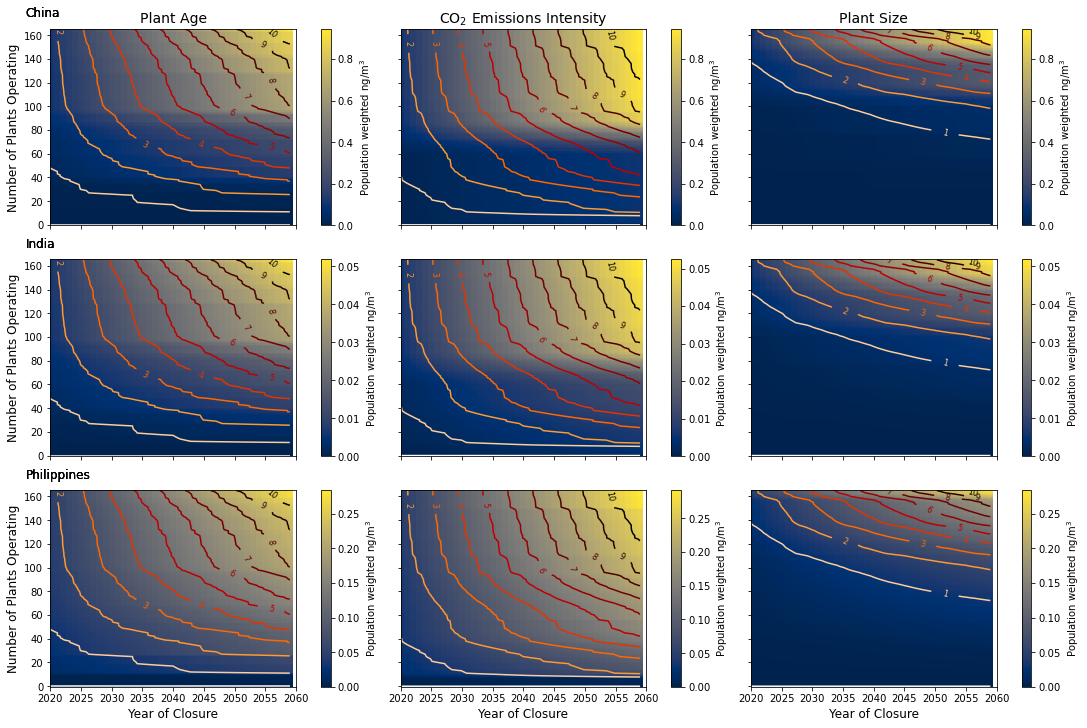

In [257]:
dict_ds = {0:'Plant Age', 1: 'CO$_2$ Emissions Intensity', 2: 'Plant Size'}
dict_vmax = {'China':220, 'India': 12, 'Philippines':70}
fig, axes = plt.subplots(3,3, figsize = (15,10), sharex = True, sharey = True, constrained_layout = True)
for idx, impacted_c in enumerate(subset_locations):
    for idx_d, ds in enumerate([age_ds, weighted_ds, mw_ds]):
        ax = axes[idx,idx_d]
        ####BC#######
        ds['BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c).plot(ax = ax, add_colorbar = True,  
                                                                                       #vmin = 0, vmax = dict_vmax[impacted_c], 
                                                                                          cmap = 'cividis',
                                                                                       cbar_kwargs = {'label':'Population weighted ng/m$^3$'})
        
        ####CO2######
        contours = (ds['co2_emissions']*1e-9).plot.contour(ax = ax, add_colorbar = False, cmap = 'gist_heat_r', 
                                   levels = np.linspace(0,10,11))
        
        plt.clabel(contours, fontsize=8, inline = True)
        #### TITLES #####
        ax.set_title(None)
        axes[0,idx_d].set_title(dict_ds[idx_d], fontsize = 14)
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        ax.set_xlim(2020,2060)
        axes[idx,0].text(-0.1, 1.06, impacted_c, transform=axes[idx,0].transAxes, fontsize = 12)
        axes[idx,0].set_ylabel(f'Number of Plants Operating', fontsize = 12);
        axes[2, idx_d].set_xlabel(f'Year of Closure', fontsize = 12);
plt.savefig('figures/paper/contours.png', bbox_inches = 'tight', dpi = 300)

## Just china

In [108]:
import string

[21.07352941 21.06735294 21.06117647 21.055      21.04882353 21.04213235
 21.03625    21.03036765 21.01786765 21.00463235 20.77816176 20.54139706
 20.30463235 20.28522059 20.26580882 20.24669118 20.22757353 20.21610294
 20.10139706 19.98669118 19.98095588 19.96948529 19.95801471 19.95205882
 19.94927941 19.9465     19.62558088 19.30466176 19.25775    19.21083824
 19.07607353 19.06541176 19.05475    19.04771324 19.04067647 18.90832353
 18.77597059 18.63655882 18.63391176 18.47891176 18.34214706 18.19170588
 17.82405882 17.68045588 17.67794853 17.67544118 17.525      17.37455882
 17.22411765 17.06911765 17.00073529 16.93235294 16.92779412 16.92323529
 16.61264706 16.58205882 16.55147059 16.40323529 16.29970588 16.135
 16.03147059 15.97264706 15.91382353 15.88227941 15.85073529 15.69786765
 15.545      15.39213235 15.23926471 15.06941176 15.06140441 15.05339706
 14.90780882 14.76222059 14.60935294 14.55597059 14.40310294 14.25310294
 14.23810294 14.18210294 14.12610294 13.97610294 13.8261

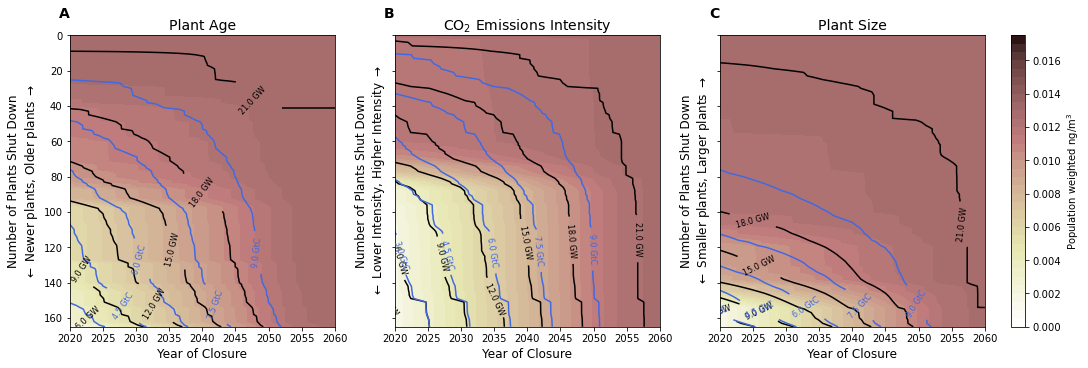

In [123]:
impacted_c = 'China'
dict_ds = {0:'Plant Age', 1: 'CO$_2$ Emissions Intensity', 2: 'Plant Size'}
dict_vmax = {'China':220, 'India': 12, 'Philippines':70}
background_dict = {0:bckg_age_ds, 1: bckg_weight_ds, 2: bckg_mw_ds}
fig, axes = plt.subplots(1,3, figsize = (15,5), sharex = True, sharey = True, constrained_layout = True)
for idx_d, ds in enumerate([age_ds, weighted_ds, mw_ds]):
    ax = axes[idx_d]
    c = ax.contourf(ds['closure_year'].values,
            np.arange(0, len((ds['MW_total']+background_dict[idx_d])['unique_ID'])),
        (ds['BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c) + background_dict[idx_d]['final_BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c)), 
                                                                               levels = np.arange(0,0.018,.0005), 
                                                                                  cmap = 'pink_r')

    ####CO2######
    contours = ax.contour(ds['closure_year'].values,
                            np.arange(0, len((ds['MW_total']+background_dict[idx_d])['unique_ID'])),
                            (ds['MW_total']+background_dict[idx_d]['final_MW_total'])/1e3, 
                            colors = 'k', 
                               #levels = np.arange(0,.1, .2)
                                                                               )
    strings = [str(np.round(i,1)) + ' GW' for i in contours.levels ]
    fmt = {}
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)


    ####CO2######
    contours = ax.contour(ds['closure_year'].values,
                            np.arange(0, len((ds['MW_total']+background_dict[idx_d])['unique_ID'])),
                (ds['co2_emissions']+background_dict[idx_d]['final_co2_emissions'])*1e-9, 
                colors = 'royalblue', #levels = np.arange(0,14,2) 
                         )
    strings = [str(np.round(i,1)) + ' GtC' for i in contours.levels ]
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)
    #### TITLES #####
    ax.set_title(dict_ds[idx_d], fontsize = 14)
    ax.set_xlabel(f'Year of Closure', fontsize = 12)
    ax.set_xlim(2020,2060)
    axes[0].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Newer plants, Older plants $\rightarrow$', fontsize = 12);
    axes[1].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Lower Intensity, Higher Intensity $\rightarrow$', fontsize = 12);
    axes[2].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Smaller plants, Larger plants $\rightarrow$', fontsize = 12);

    ax.text(-0.04, 1.06, string.ascii_uppercase[idx_d], transform=ax.transAxes, 
            size=14, weight='bold')
    
    ax.invert_yaxis()
plt.colorbar(c, label ='Population weighted ng/m$^3$')
plt.savefig('figures/paper/contours_china.png', bbox_inches = 'tight', dpi = 300)

## Just china from Vietnam

In [114]:
vietnam_ds = full_ds.where(full_ds.country_emitting == 'VIETNAM', drop = True)

In [115]:

vietnam_age_ds = {}
bckg_vietnam_age_ds = {}
for idx, val in enumerate(vietnam_ds['unique_ID'].values):
    vietnam_age_ds[idx] = vietnam_ds.sortby(
                     ['Year_of_Commission'], ascending = True).isel(unique_ID = slice(0,idx)).sum(dim = ['unique_ID'])
    bckg_vietnam_age_ds[idx] = vietnam_ds.sortby(
                     ['Year_of_Commission'], ascending = True).isel(unique_ID = slice(idx, -1)).sum(dim = ['unique_ID'])
    
vietnam_age_ds = xr.concat([vietnam_age_ds[t] for t in vietnam_age_ds.keys()], pd.Index([t for t in vietnam_age_ds.keys()], name='unique_ID'), join = 'outer')
bckg_vietnam_age_ds = xr.concat([bckg_vietnam_age_ds[t] for t in bckg_vietnam_age_ds.keys()], pd.Index([t for t in bckg_vietnam_age_ds.keys()], name='unique_ID'), join = 'outer')

vietnam_weighted_ds = {}
bckg_vietnam_weighted_ds = {}
for idx, val in enumerate(vietnam_ds['unique_ID'].values):
    vietnam_weighted_ds[idx] = vietnam_ds.sortby(
                     ['CO2_weighted_capacity_1000tonsperMW'], ascending = True).isel(unique_ID = slice(0,idx)).sum(dim = ['unique_ID'])
    bckg_vietnam_weighted_ds[idx] = vietnam_ds.sortby(
                     ['CO2_weighted_capacity_1000tonsperMW'], ascending = True).isel(unique_ID = slice(idx, -1)).sum(dim = ['unique_ID'])
    
vietnam_weighted_ds = xr.concat([vietnam_weighted_ds[t] for t in vietnam_weighted_ds.keys()], pd.Index([t for t in vietnam_weighted_ds.keys()], name='unique_ID'), join = 'outer')
bckg_vietnam_weighted_ds = xr.concat([bckg_vietnam_weighted_ds[t] for t in bckg_vietnam_weighted_ds.keys()], pd.Index([t for t in bckg_vietnam_weighted_ds.keys()], name='unique_ID'), join = 'outer')

vietnam_mw_ds = {}
bckg_vietnam_mw_ds = {}
for idx, val in enumerate(vietnam_ds['unique_ID'].values):
    vietnam_mw_ds[idx] = vietnam_ds.sortby(
                     ['MW'], ascending = True).isel(unique_ID = slice(0,idx)).sum(dim = ['unique_ID'])
    bckg_vietnam_mw_ds[idx] = vietnam_ds.sortby(
                     ['MW'], ascending = True).isel(unique_ID = slice(idx, -1)).sum(dim = ['unique_ID'])
    
vietnam_mw_ds = xr.concat([vietnam_mw_ds[t] for t in vietnam_mw_ds.keys()], pd.Index([t for t in vietnam_mw_ds.keys()], name='unique_ID'), join = 'outer')
bckg_vietnam_mw_ds = xr.concat([bckg_vietnam_mw_ds[t] for t in bckg_vietnam_mw_ds.keys()], pd.Index([t for t in bckg_vietnam_mw_ds.keys()], name='unique_ID'), join = 'outer')


dict_ds = {0:'Plant Age', 1: 'CO$_2$ Emissions Intensity', 2: 'Plant Size'}
fig, axes = plt.subplots(1,3, figsize = (15,5), sharex = True, sharey = True, constrained_layout = True)
for idx_d, ds in enumerate([vietnam_age_ds, vietnam_weighted_ds, vietnam_mw_ds]):
    ax = axes[idx_d]
    ####BC#######
    contours = ds['BC_forcing'].plot.contour(ax = ax, add_colorbar = False,  
                           #vmin = 0, vmax = dict_vmax[impacted_c], 
                              cmap = 'green')
    plt.clabel(contours, fontsize=8, inline = True)
    ####CO2######
    contours = (ds['co2_emissions']*1e-9).plot.contour(ax = ax, add_colorbar = False, cmap = 'black', 
                               levels = np.linspace(0,2.5, 6))

    plt.clabel(contours, fontsize=8, inline = True)
    #### TITLES #####
    ax.set_title(None)
    ax.set_title(dict_ds[idx_d], fontsize = 14)
    ax.set_ylabel(None)
    ax.set_xlim(2020,2060)
    axes[0].set_ylabel(f'Number of Plants Operating', fontsize = 12);
    ax.set_xlabel(f'Year of Closure', fontsize = 12);
#plt.savefig('figures/paper/contours_mw.png', bbox_inches = 'tight', dpi = 300)

1.7324025263854916
4.8058676470588235
0.007436095322643792
1.7732556948883265
4.952375
0.007681128599268956
1.7201962924214913
4.762963235294117
0.007416626059265936


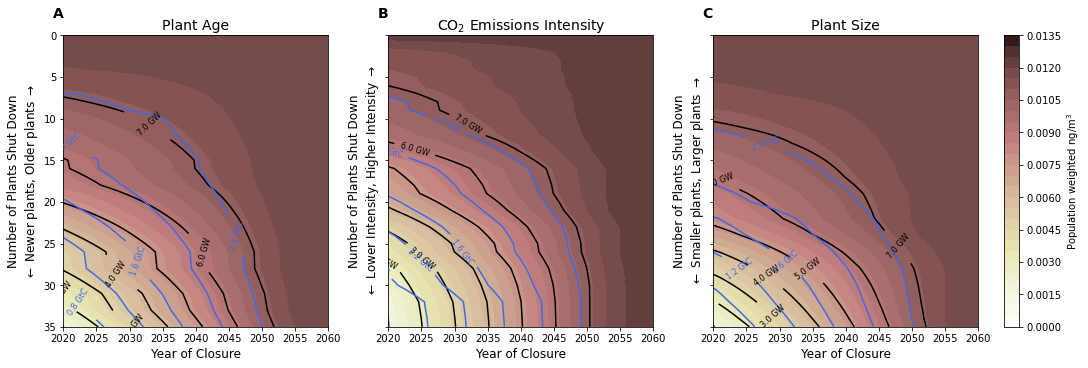

In [120]:
impacted_c = 'China'
dict_ds = {0:'Plant Age', 1: 'CO$_2$ Emissions Intensity', 2: 'Plant Size'}
dict_vmax = {'China':220, 'India': 12, 'Philippines':70}
background_dict = {0:bckg_vietnam_age_ds, 1: bckg_vietnam_weighted_ds, 2: bckg_vietnam_mw_ds}
fig, axes = plt.subplots(1,3, figsize = (15,5), sharex = True, sharey = True, constrained_layout = True)
for idx_d, ds in enumerate([vietnam_age_ds, vietnam_weighted_ds, vietnam_mw_ds]):
    ax = axes[idx_d]
    c = ax.contourf(ds['closure_year'].values,
            np.arange(0, len((ds['MW_total']+background_dict[idx_d])['unique_ID'])),
        (ds['BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c) + background_dict[idx_d]['final_BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c)), 
                                                                               levels = np.arange(0,0.014,.0005), 
                                                                                  cmap = 'pink_r')

    ####CO2######
    contours = ax.contour(ds['closure_year'].values,
                            np.arange(0, len((ds['MW_total']+background_dict[idx_d])['unique_ID'])),
                            (ds['MW_total']+background_dict[idx_d]['final_MW_total'])/1e3, 
                            colors = 'k', 
                               #levels = np.arange(0,.8, .1)
                                                                               )
    strings = [str(np.round(i,1)) + ' GW' for i in contours.levels ]
    fmt = {}
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)


    ####CO2######
    contours = ax.contour(ds['closure_year'].values,
                            np.arange(0, len((ds['MW_total']+background_dict[idx_d])['unique_ID'])),
                (ds['co2_emissions']+background_dict[idx_d]['final_co2_emissions'])*1e-9, 
                colors = 'royalblue', #levels = np.arange(0,6,0.5) 
                         )
    strings = [str(np.round(i,1)) + ' GtC' for i in contours.levels ]
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)
    #### TITLES #####
    ax.set_title(dict_ds[idx_d], fontsize = 14)
    ax.set_xlabel(f'Year of Closure', fontsize = 12)
    ax.set_xlim(2020,2060)
    axes[0].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Newer plants, Older plants $\rightarrow$', fontsize = 12);
    axes[1].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Lower Intensity, Higher Intensity $\rightarrow$', fontsize = 12);
    axes[2].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Smaller plants, Larger plants $\rightarrow$', fontsize = 12);

    ax.text(-0.04, 1.06, string.ascii_uppercase[idx_d], transform=ax.transAxes, 
            size=14, weight='bold')
    
    ax.invert_yaxis()
    print((ds['co2_emissions']+background_dict[idx_d]['final_co2_emissions']).sel(closure_year = 2040, unique_ID = 35).values/1e9)
    print((ds['MW_total']+background_dict[idx_d]['final_MW_total']).sel(closure_year = 2040, unique_ID = 35).values/1e3)
    print((ds['BC_pop_weight_mean_conc']+background_dict[idx_d]['final_BC_pop_weight_mean_conc']).sel(country_impacted = impacted_c).sel(closure_year = 2040, unique_ID = 35).values)

plt.colorbar(c, label ='Population weighted ng/m$^3$')
plt.savefig('figures/paper/contours_china_from_vietnam.png', bbox_inches = 'tight', dpi = 300)

## Just oldest plants from all countries

In [114]:


malay_age_ds = {}
for idx in np.arange(0,len(full_ds.where(full_ds.country_emitting == 'MALAYSIA', drop = True)['unique_ID'])):
    malay_age_ds[idx] = full_ds.where(full_ds.country_emitting == 'MALAYSIA', drop = True).sortby(
                     ['Year_of_Commission'], ascending = True).isel(unique_ID = slice(0,idx)).sum(dim = ['unique_ID'])
malay_age_ds = xr.concat([malay_age_ds[t] for t in malay_age_ds.keys()], pd.Index([t for t in malay_age_ds.keys()], name='num_plants_comis_yr'), join = 'outer')



cambod_age_ds = {}
for idx in np.arange(0,len(full_ds.where(full_ds.country_emitting == 'CAMBODIA', drop = True)['unique_ID'])):
    cambod_age_ds[idx] = full_ds.where(full_ds.country_emitting == 'CAMBODIA', drop = True).sortby(
                     ['Year_of_Commission'], ascending = True).isel(unique_ID = slice(0,idx)).sum(dim = ['unique_ID'])
cambod_age_ds = xr.concat([cambod_age_ds[t] for t in cambod_age_ds.keys()], pd.Index([t for t in cambod_age_ds.keys()], name='num_plants_comis_yr'), join = 'outer')



indo_age_ds = {}
for idx in np.arange(0,len(full_ds.where(full_ds.country_emitting == 'INDONESIA', drop = True)['unique_ID'])):
    indo_age_ds[idx] = full_ds.where(full_ds.country_emitting == 'INDONESIA', drop = True).sortby(
                     ['Year_of_Commission'], ascending = True).isel(unique_ID = slice(0,idx)).sum(dim = ['unique_ID'])
indo_age_ds = xr.concat([indo_age_ds[t] for t in indo_age_ds.keys()], pd.Index([t for t in indo_age_ds.keys()], name='num_plants_comis_yr'), join = 'outer')


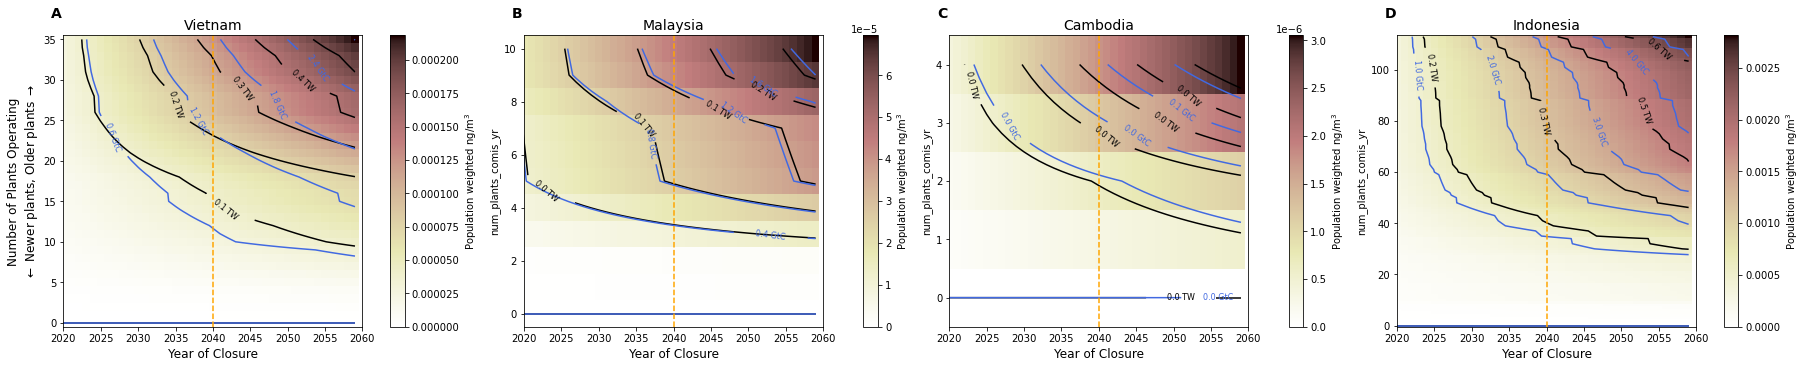

In [118]:
impacted_c = 'Australia'
dict_ds = {0:'Vietnam', 1: 'Malaysia', 2: 'Cambodia', 3: 'Indonesia'}
dict_vmax = {'China':220, 'India': 12, 'Philippines':70}
fig, axes = plt.subplots(1,4, figsize = (25,5), sharex = True, sharey = False, constrained_layout = True)
for idx_d, ds in enumerate([viet_age_ds, malay_age_ds, cambod_age_ds, indo_age_ds]):
    idx = 0
    ax = axes[idx_d]
    ####BC#######
    ds['BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c).plot(ax = ax, add_colorbar = True,  
                                                                                   #vmin = 0, vmax = 0.8, 
                                                                                      cmap = 'pink_r',
                                                                                    cbar_kwargs = {'label':'Population weighted ng/m$^3$'})
   
    ####CO2######
    contours = (ds['MW_total']/1e6).plot.contour(ax = ax, add_colorbar = False, cmap = 'k', 
                              # levels = np.linspace(0,.5, 6)
                                                )
    strings = [str(np.round(i,1)) + ' TW' for i in contours.levels ]
    fmt = {}
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)


    ####CO2######
    contours = (ds['co2_emissions']*1e-9).plot.contour(ax = ax, add_colorbar = False, cmap = 'royalblue', 
                              # levels = np.linspace(0,2.5,6)
                                                      )
    strings = [str(np.round(i,1)) + ' GtC' for i in contours.levels ]
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)
    #### TITLES #####
    ax.set_title(dict_ds[idx_d], fontsize = 14)
    ax.set_xlabel(f'Year of Closure', fontsize = 12)
    ax.set_xlim(2020,2060)
    axes[0].set_ylabel('Number of Plants Operating\n' + r'$\leftarrow$ Newer plants, Older plants $\rightarrow$', fontsize = 12);

    ax.text(-0.04, 1.06, string.ascii_uppercase[idx_d], transform=ax.transAxes, 
            size=14, weight='bold')
    ax.axvline(2040, linestyle = '--', color = 'orange')
#plt.savefig('figures/paper/contours_china_from_vietnam.png', bbox_inches = 'tight', dpi = 300)

In [ ]:
impacted_c = 'China'
dict_ds = {0:'Plant Age', 1: 'CO$_2$ Emissions Intensity', 2: 'Plant Size'}
dict_vmax = {'China':220, 'India': 12, 'Philippines':70}
background_dict = {0:bckg_vietnam_age_ds, 1: bckg_vietnam_weighted_ds, 2: bckg_vietnam_mw_ds}
fig, axes = plt.subplots(1,3, figsize = (15,5), sharex = True, sharey = True, constrained_layout = True)
for idx_d, ds in enumerate([vietnam_age_ds, vietnam_weighted_ds, vietnam_mw_ds]):
    ax = axes[idx_d]
    c = ax.contourf(ds['closure_year'].values,
            np.arange(0, len((ds['MW_total']+background_dict[idx_d])['unique_ID'])),
        (ds['BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c) + background_dict[idx_d]['final_BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c)), 
                                                                               levels = np.arange(0,0.014,.0005), 
                                                                                  cmap = 'pink_r')

    ####CO2######
    contours = ax.contour(ds['closure_year'].values,
                            np.arange(0, len((ds['MW_total']+background_dict[idx_d])['unique_ID'])),
                            (ds['MW_total']+background_dict[idx_d]['final_MW_total'])/1e3, 
                            colors = 'k', 
                               #levels = np.arange(0,.8, .1)
                                                                               )
    strings = [str(np.round(i,1)) + ' GW' for i in contours.levels ]
    fmt = {}
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)


    ####CO2######
    contours = ax.contour(ds['closure_year'].values,
                            np.arange(0, len((ds['MW_total']+background_dict[idx_d])['unique_ID'])),
                (ds['co2_emissions']+background_dict[idx_d]['final_co2_emissions'])*1e-9, 
                colors = 'royalblue', #levels = np.arange(0,6,0.5) 
                         )
    strings = [str(np.round(i,1)) + ' GtC' for i in contours.levels ]
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)
    #### TITLES #####
    ax.set_title(dict_ds[idx_d], fontsize = 14)
    ax.set_xlabel(f'Year of Closure', fontsize = 12)
    ax.set_xlim(2020,2060)
    axes[0].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Newer plants, Older plants $\rightarrow$', fontsize = 12);
    axes[1].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Lower Intensity, Higher Intensity $\rightarrow$', fontsize = 12);
    axes[2].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Smaller plants, Larger plants $\rightarrow$', fontsize = 12);

    ax.text(-0.04, 1.06, string.ascii_uppercase[idx_d], transform=ax.transAxes, 
            size=14, weight='bold')
    
    ax.invert_yaxis()
    print((ds['co2_emissions']+background_dict[idx_d]['final_co2_emissions']).sel(closure_year = 2040, unique_ID = 35).values/1e9)
    print((ds['MW_total']+background_dict[idx_d]['final_MW_total']).sel(closure_year = 2040, unique_ID = 35).values/1e3)
    print((ds['BC_pop_weight_mean_conc']+background_dict[idx_d]['final_BC_pop_weight_mean_conc']).sel(country_impacted = impacted_c).sel(closure_year = 2040, unique_ID = 35).values)

plt.colorbar(c, label ='Population weighted ng/m$^3$')
plt.savefig('figures/paper/contours_china_from_vietnam.png', bbox_inches = 'tight', dpi = 300)

/tmp/ipykernel_552/789825327.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(a)


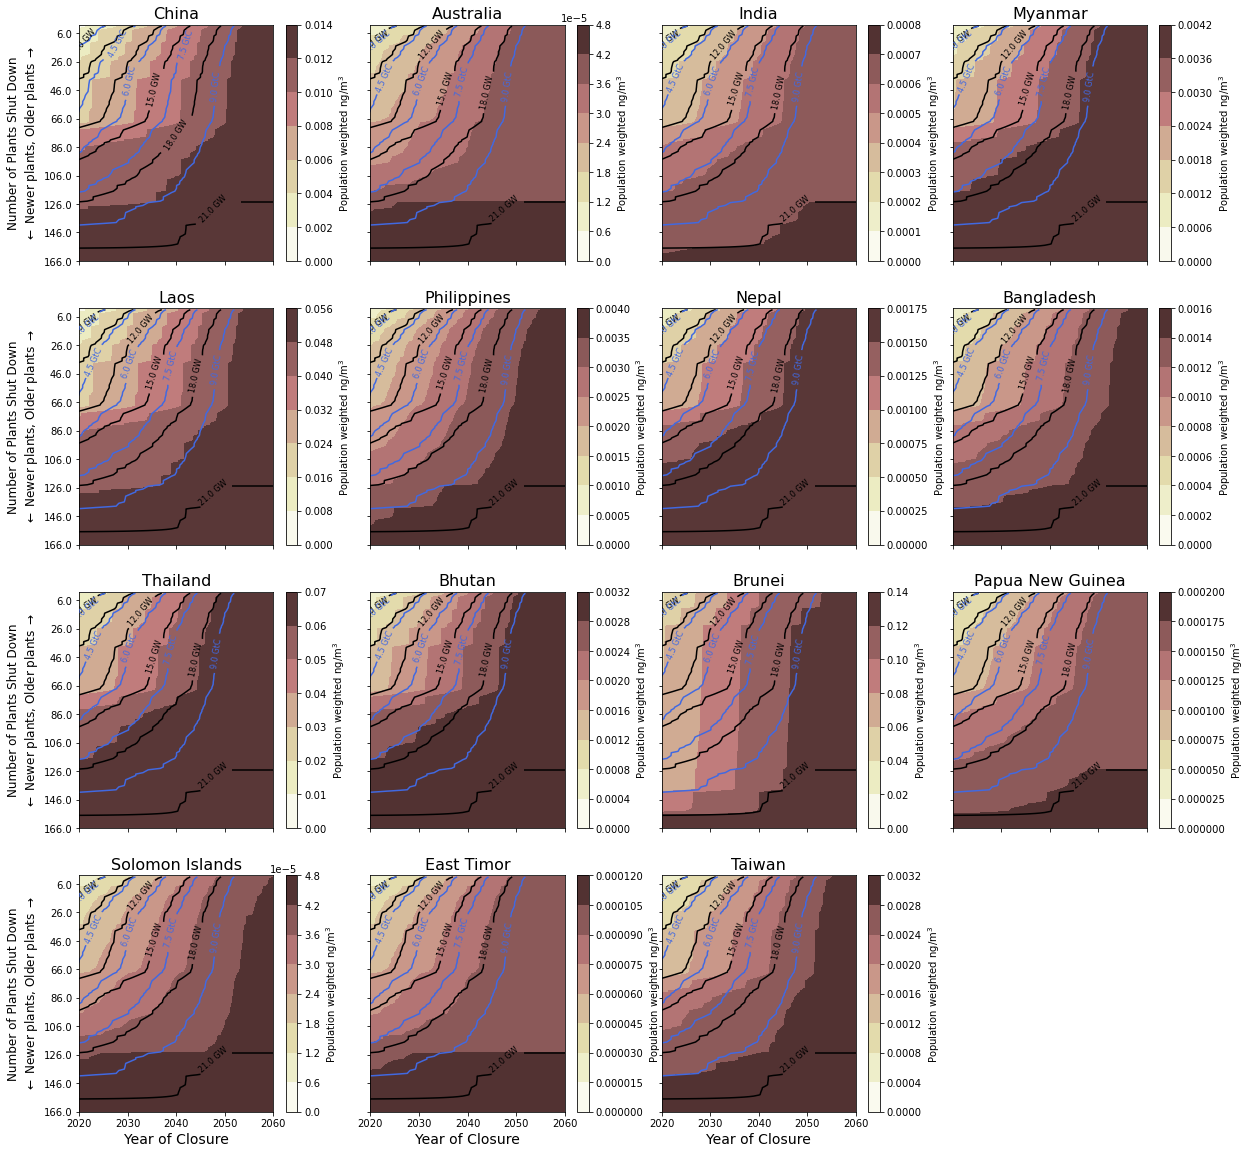

In [65]:
fig, axes = plt.subplots(4,4, figsize = (20,20), sharex = True, sharey = True)
for ax, impacted_c in zip(axes.ravel(), impacted_countries):
    c = ax.contourf(age_ds['closure_year'].values,
            np.arange(0, len((age_ds['MW_total']+bckg_age_ds)['unique_ID'])),
        (age_ds['BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c) + bckg_age_ds['final_BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c)), 
                                                                               #levels = np.arange(0,0.014,.0005), 
                                                                                  cmap = 'pink_r')
    plt.colorbar(c, ax = ax, label ='Population weighted ng/m$^3$')
    ####CO2######
    contours = ax.contour(age_ds['closure_year'].values,
                            np.arange(0, len((age_ds['MW_total']+bckg_age_ds)['unique_ID'])),
                            (age_ds['MW_total']+bckg_age_ds['final_MW_total'])/1e3, 
                            colors = 'k', 
                               #levels = np.arange(0,.8, .1)
                                                                               )
    strings = [str(np.round(i,1)) + ' GW' for i in contours.levels ]
    fmt = {}
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)


    ####CO2######
    contours = ax.contour(age_ds['closure_year'].values,
                            np.arange(0, len((age_ds['MW_total']+bckg_age_ds)['unique_ID'])),
                (age_ds['co2_emissions']+bckg_age_ds['final_co2_emissions'])*1e-9, 
                colors = 'royalblue', #levels = np.arange(0,6,0.5) 
                         )
    strings = [str(np.round(i,1)) + ' GtC' for i in contours.levels ]
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)
        
    ax.set_title(impacted_c, fontsize = 16)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xlim(2020,2060)
for idx in np.arange(0,4):
    axes[idx,0].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Newer plants, Older plants $\rightarrow$', fontsize = 12);

    axes[3, idx].set_xlabel(f'Year of Closure', fontsize = 14);
    

    ax.set_ylim(0,166)
    a = ax.get_yticks().tolist()
    for idx, num in enumerate(a):
        a[idx] = 166 - num
    ax.set_yticklabels(a)
    
fig.delaxes(axes[3,3])
plt.savefig('figures/supplement/supp_age_retire_all.png', bbox_inches = 'tight', dpi = 300)



/tmp/ipykernel_552/3153466768.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(a)


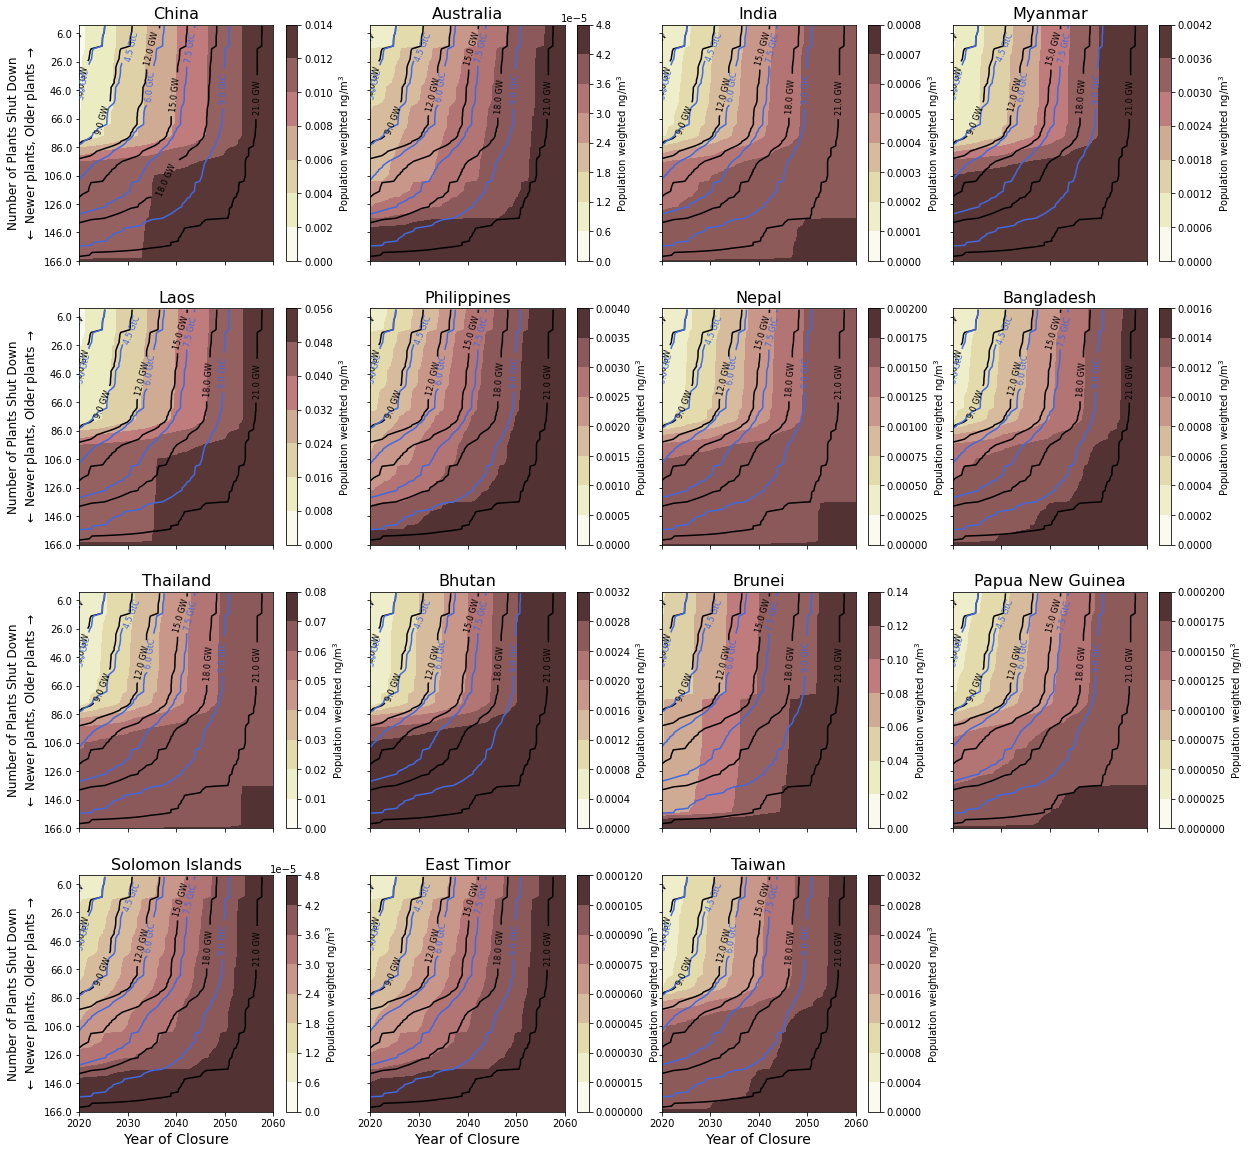

In [69]:
fig, axes = plt.subplots(4,4, figsize = (20,20), sharex = True, sharey = True)
for ax, impacted_c in zip(axes.ravel(), impacted_countries):
    c = ax.contourf(weighted_ds['closure_year'].values,
            np.arange(0, len((weighted_ds['MW_total']+bckg_weighted_ds)['unique_ID'])),
        (weighted_ds['BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c) + bckg_weighted_ds['final_BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c)), 
                                                                               #levels = np.arange(0,0.014,.0005), 
                                                                                  cmap = 'pink_r')
    plt.colorbar(c, ax = ax, label ='Population weighted ng/m$^3$')
    ####CO2######
    contours = ax.contour(weighted_ds['closure_year'].values,
                            np.arange(0, len((weighted_ds['MW_total']+bckg_weighted_ds)['unique_ID'])),
                            (weighted_ds['MW_total']+bckg_weighted_ds['final_MW_total'])/1e3, 
                            colors = 'k', 
                               #levels = np.arange(0,.8, .1)
                                                                               )
    strings = [str(np.round(i,1)) + ' GW' for i in contours.levels ]
    fmt = {}
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)


    ####CO2######
    contours = ax.contour(weighted_ds['closure_year'].values,
                            np.arange(0, len((weighted_ds['MW_total']+bckg_weighted_ds)['unique_ID'])),
                (weighted_ds['co2_emissions']+bckg_weighted_ds['final_co2_emissions'])*1e-9, 
                colors = 'royalblue', #levels = np.arange(0,6,0.5) 
                         )
    strings = [str(np.round(i,1)) + ' GtC' for i in contours.levels ]
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)
        
    ax.set_title(impacted_c, fontsize = 16)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xlim(2020,2060)
for idx in np.arange(0,4):
    axes[idx,0].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Newer plants, Older plants $\rightarrow$', fontsize = 12);

    axes[3, idx].set_xlabel(f'Year of Closure', fontsize = 14);
    

    ax.set_ylim(0,166)
    a = ax.get_yticks().tolist()
    for idx, num in enumerate(a):
        a[idx] = 166 - num
    ax.set_yticklabels(a)
    
fig.delaxes(axes[3,3])

plt.savefig('figures/supplement/supp_emisfactor_co2_all.png', bbox_inches = 'tight', dpi = 300)



/tmp/ipykernel_552/1070408945.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(a)


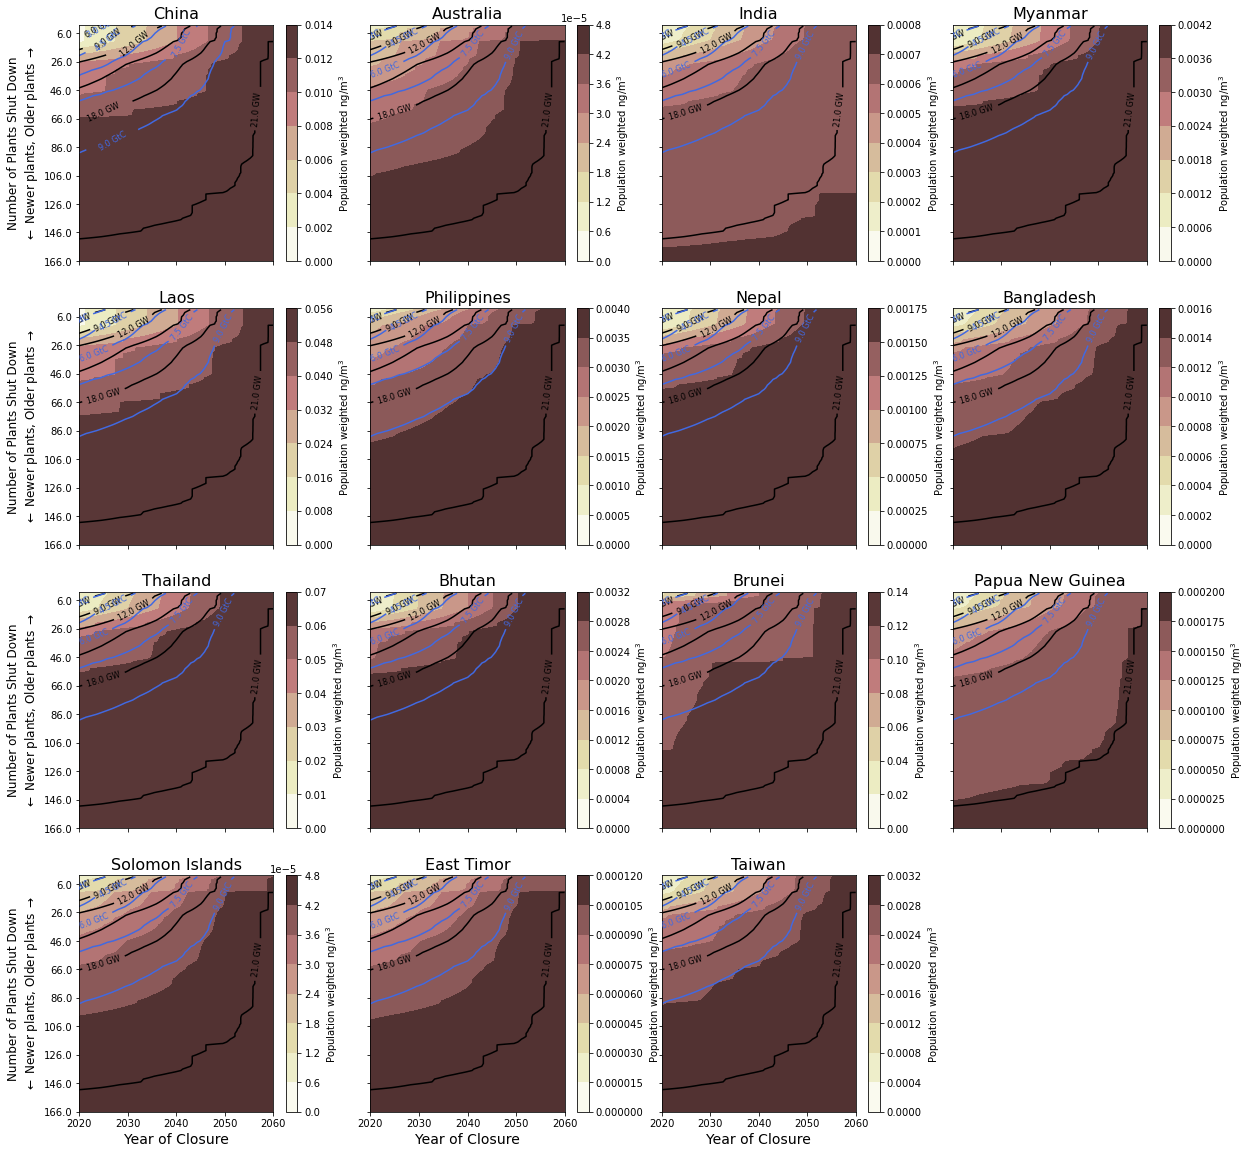

In [70]:
fig, axes = plt.subplots(4,4, figsize = (20,20), sharex = True, sharey = True)
for ax, impacted_c in zip(axes.ravel(), impacted_countries):
    c = ax.contourf(mw_ds['closure_year'].values,
            np.arange(0, len((mw_ds['MW_total']+bckg_mw_ds)['unique_ID'])),
        (mw_ds['BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c) + bckg_mw_ds['final_BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c)), 
                                                                               #levels = np.arange(0,0.014,.0005), 
                                                                                  cmap = 'pink_r')
    plt.colorbar(c, ax = ax, label ='Population weighted ng/m$^3$')
    ####CO2######
    contours = ax.contour(mw_ds['closure_year'].values,
                            np.arange(0, len((mw_ds['MW_total']+bckg_mw_ds)['unique_ID'])),
                            (mw_ds['MW_total']+bckg_mw_ds['final_MW_total'])/1e3, 
                            colors = 'k', 
                               #levels = np.arange(0,.8, .1)
                                                                               )
    strings = [str(np.round(i,1)) + ' GW' for i in contours.levels ]
    fmt = {}
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)


    ####CO2######
    contours = ax.contour(mw_ds['closure_year'].values,
                            np.arange(0, len((mw_ds['MW_total']+bckg_mw_ds)['unique_ID'])),
                (mw_ds['co2_emissions']+bckg_mw_ds['final_co2_emissions'])*1e-9, 
                colors = 'royalblue', #levels = np.arange(0,6,0.5) 
                         )
    strings = [str(np.round(i,1)) + ' GtC' for i in contours.levels ]
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)
        
    ax.set_title(impacted_c, fontsize = 16)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xlim(2020,2060)
for idx in np.arange(0,4):
    axes[idx,0].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Newer plants, Older plants $\rightarrow$', fontsize = 12);

    axes[3, idx].set_xlabel(f'Year of Closure', fontsize = 14);
    

    ax.set_ylim(0,166)
    a = ax.get_yticks().tolist()
    for idx, num in enumerate(a):
        a[idx] = 166 - num
    ax.set_yticklabels(a)
    
fig.delaxes(axes[3,3])

plt.savefig('figures/supplement/supp_mw_all.png', bbox_inches = 'tight', dpi = 300)

